In [1]:
###################################################################
#                      Document History                           #
#                                                                 #
#    Author: Dr Ji Zhou (EI/JIC)                                  #         
#               <ji.zhou@tgac.ac.uk>                              # 
#            Dr Christopher Applegate (The Zhou lab, EI)          #
#               <Christopher.Applegate@earlham.ac.uk>             #
#                                                                 #
#    Date: May 2017, Version: 1.18 on TGAC internal Github        #
#    Changes: 1) Hanlde wheat images series                       #
#             3) profiled code for distribution                   #
#             4) optimsed for paralle computing libraries         #
#                                                                 #
###################################################################

#STEP 1: Import libraries 
% matplotlib inline

# Essential libraries 
import numpy as np
import scipy as sp

# Computer vision libraries 
from scipy import ndimage
from skimage.color import rgb2gray
from skimage import io 
# All other skimage functions will be listed with the code fragments below
import cv2
from matplotlib import pyplot as plt # Plotting and generating figures

# Other libraries
import math # Feature measures 
import os # Access the file system
import gc # Garbage collection 
import csv # For results output
import sys # for operating systems 
gc.enable()

In [2]:
#STEP 2: Enable GUI interactions for users to select an image file 
#        in iPython Notebook to locate an image series

##STEP 2.1: GUI dialog panel to locate where to import images 
import Tkinter, tkFileDialog

# Make a top-level instance, but without displaying it
# Use Tkinter for GUI interactions 
root = Tkinter.Tk() 
root.withdraw()
root.overrideredirect(True) 

# Invisible without decorations, 0 size, to the top left corner.
root.geometry('0x0+0+0')
root.deiconify() # show window and lift it to top position
root.lift() # Place the dialog panel before the terminal.
root.focus_force()

# Assign the selected filename with a full path
fullname = tkFileDialog.askopenfilename(parent=root)
root.destroy() 
# get rid of the top-level instance 
# Finish read the full path from local file system

In [3]:
# Function_0 
# Cross-platform delimiter 

def PlatformDelimiter(): 
    """Generate Delimiter based on Platforms"""
    # Current OS 
    OS_Delimiter = ''
    if sys.platform == 'win32':
        # windows codes
        OS_Delimiter = '\\'
    elif sys.platform == 'darwin':
        # mac codes
        OS_Delimiter = '/' 
    else:
        # other code here (linux)
        OS_Delimiter = '/' 
    # Return the delimiter     
    return OS_Delimiter

In [4]:
##STEP 2.2: Reassemble the directory of the selected image 
import glob # Find all the pathnames matching a specified pattern

# Get the full path of the image
fullPath = fullname.split("/", -1) 
# The following can handle different platforms
Platform_Delimiter = PlatformDelimiter()
fullPathRef = Platform_Delimiter.join(fullPath[: -1]) + Platform_Delimiter
print 'The selected image: ', fullname
print 'The full path: ', fullPathRef

##STEP 2.3 Start to prepare a folder to save processing results
CurrentDir = os.getcwd()
# print CurrentDir 
tmp_Folders = [] 
tmp_Folders_Final = []
workingRootFolder = fullPathRef
# Locate the image directoriy 
print "The working directory: ",workingRootFolder

# Loop through the working folder, testing for batch processing 
for root, dirs, files in os.walk(workingRootFolder):
    Work_Dir_Root = root
    tmp_Folders.append(dirs)
    tmp_Folders_Final = filter(None, tmp_Folders) 
    # A fast way to get rid of empty element while using os.walk 
    # when going through a file instead of a folder
    
# Directories found in the root folder 
if not len(tmp_Folders_Final) == 0:
    workDirFolders = tmp_Folders_Final[0] 
else: 
    workDirFolders = workingRootFolder
# First level of the working directory, use ONE to search the second level of the directory
# In case this folder has been processed
print "Folders found in the selected directory: ", workDirFolders

The selected image:  /Users/zhouj/Documents/My papers/LeafSeg/Data for publication/Wheat/Refined/2016-03-20_Par_WT_DayTemp_Tray_1.jpg
The full path:  /Users/zhouj/Documents/My papers/LeafSeg/Data for publication/Wheat/Refined/
The working directory:  /Users/zhouj/Documents/My papers/LeafSeg/Data for publication/Wheat/Refined/
Folders found in the selected directory:  /Users/zhouj/Documents/My papers/LeafSeg/Data for publication/Wheat/Refined/


In [5]:
# Function_1 
# Return the current date and time based on the OS
import time
from datetime import datetime, timedelta

def LocalTimeStamp(): 
    """Detect curret data and time"""
    # Current OS date and time 
    currentDate = time.localtime(time.time())
    return currentDate

In [6]:
##STEP 2.4: Set up a result folder to contain the processing results  
# Sort different image datasets included in the GUI system 

# Get the pre-processing date 
timeStamp = LocalTimeStamp()
curYear = timeStamp[0]
curMonth = timeStamp[1]
curDay = timeStamp[2]

# Assemble a result folder for processed results
Result_Folder =  'Processed_%d' %curYear + '-%d' %curMonth + '-%d' %curDay
Result_Directory = workingRootFolder + Result_Folder

# If the user repeats the image selection with different criteria 
if not os.path.exists(Result_Directory):
    os.makedirs(Result_Directory)
# Folder for processed results 
print 'Result folder: ', Result_Directory

Result folder:  /Users/zhouj/Documents/My papers/LeafSeg/Data for publication/Wheat/Refined/Processed_2017-6-27


In [7]:
# Function_2
# Locate the red reference points 

def RefPoints_Wheat(ref_image, blank_image):
    """Locate red reference points"""
    # STEP 1: Locate red pixels
    # R >= 150, B <= 100, and G <= 100, due to colour distortion  
    Ref_Points_Red = ref_image[:, :, 0] > 125
    # Use blue channel to remove the white pixels
    Ref_Points_Blue = ref_image[:, :, 2] < 225
    Ref_Points_Color_Selection_1 = np.logical_and(Ref_Points_Red, Ref_Points_Blue)
    # Add second approach based on the difference between red and green channles 
    Ref_Points_Color_Selection_2 = np.array(ref_image[:,:,0], dtype='int')-np.array(ref_image[:,:,1], dtype="int")>50
    
    # STEP 2: Extract Red ref points from the previous mask 
    Ref_Points_Refined = np.logical_and(Ref_Points_Color_Selection_1, Ref_Points_Color_Selection_2)
    Ref_Point = remove_small_objects(Ref_Points_Refined, 25) # get rid of small pixels, as the resolution is fixed 
    Fill_Ref_Points = ndimage.binary_fill_holes(Ref_Point)

    ## Create a list for the areas of the detected red circular reference points 
    Ref_Point_Areas = []
    Ref_Point_Array = []
    # Start to Label the Red reference points
    Labelled_Ref_Point = label(Fill_Ref_Points, connectivity =1)
    processed_Ref_Img = blank_image.copy()
    Obj_counter = 0
    maxLength = Ref_Points_Refined.shape[1]/25
    minLength = Ref_Points_Refined.shape[1]/55
    # Go through every red reference point objects
    for region in regionprops(Labelled_Ref_Point): 
        Ref_Tmp_Img = blank_image.copy()
        if region.area < 125:
            continue
        # Purely based on morphology features
        if region.solidity < 0.75: # Compare ref points with their convex areas.
            continue
        if region.eccentricity > 0.75: # These ref points are not totally round.
            continue
        # get 2D coordinates of the ref points
        Obj_counter = Obj_counter + 1 
        # print "ID: ", str(Obj_counter), 'Centroid: ', int(region.centroid[0]), int(region.centroid[1])
        pot_row_max = [region.bbox[2], ref_image.shape[0]]
        # column first (y) and then row (x)
        Ref_Point_Array.append([int(region.centroid[1]), int(region.centroid[0])])
        Ref_Point_Areas.append(region.area)
        Ref_coord = region.coords.astype(int)
        Ref_Tmp_Img[Ref_coord[:,0], Ref_coord[:,1]] = 1
        # Generate the final mask
        processed_Ref_Img = np.logical_or(processed_Ref_Img, Ref_Tmp_Img)
        
    # Set up empty arraies for boundary
    Upper_Left_Point = []
    Lower_Left_Point = []
    Upper_Right_Point = []
    Lower_Right_Point = []

    centre_x, centre_y = ([], []) 
    centre_x = np.sum([i[0] for i in Ref_Point_Array])/4
    centre_y = np.sum([i[1] for i in Ref_Point_Array])/4
    # Sort the position of red reference points on the image 
    for x_coor, y_coor in Ref_Point_Array:
        if x_coor < centre_x and y_coor < centre_y:
            Upper_Left_Point.append([x_coor, y_coor])
        if x_coor < centre_x and y_coor > centre_y:
            Lower_Left_Point.append([x_coor, y_coor])
        if x_coor > centre_x and y_coor < centre_y:
            Upper_Right_Point.append([x_coor, y_coor])
        if x_coor > centre_x and y_coor > centre_y:
            Lower_Right_Point.append([x_coor, y_coor])
        
    Ref_Point_Array_Ref = []        
    Ref_Point_Array_Ref.append(Upper_Left_Point[0])
    Ref_Point_Array_Ref.append(Upper_Right_Point[0])
    Ref_Point_Array_Ref.append(Lower_Left_Point[0])
    Ref_Point_Array_Ref.append(Lower_Right_Point[0])

    # Return the Red reference points' coordindates
    return Ref_Point_Array_Ref, Ref_Point_Areas, processed_Ref_Img

In [8]:
# Function_3
# Calcuale the pixel to mm conversion 

def convert_pixels_to_mm(pixels_in_circ, circle_width):
    """pixels_in_circ is the array of `region.area`s"""
    averagePixelArea = np.mean(pixels_in_circ)
    # Calculate the pixel to mm conversion rate 
    pixels_per_mm = round(math.sqrt(averagePixelArea/math.pi)/circle_width, 2)
    return(pixels_per_mm)

In [9]:
# Function_4
# Flatten an image for pixel rescaling  

def flatten_img(img):
    """Convert an image with size (M, N, 3) to (M * N, 3). 
    Flatten pixels into a 1D array where each row is a pixel and the columns are RGB values.
    """
    # The image needs to contain 3 channels...
    result_image = img.reshape((np.multiply(*img.shape[:2]), 3))
    return result_image

In [10]:
# Function_5
# Perform perspective transformation, OpenCV is used to improve the performance 

def PerspectiveTrans_2D_Wheat(ref_image, Ref_Point_Array):
    """Perform perspective transformation in 2D"""
    # Read the original image for 2D resolution 
    img = ref_image.copy()
    rows,cols,ch = img.shape
    # rows - y axis; cols - x axis 
    Reference_Distance_x = math.sqrt((Ref_Point_Array[0][0]-Ref_Point_Array[1][0])**2 + 
                                 (Ref_Point_Array[0][1]-Ref_Point_Array[1][1])**2)
    Reference_Distance_y = math.sqrt((Ref_Point_Array[0][0]-Ref_Point_Array[2][0])**2 + 
                                 (Ref_Point_Array[0][1]-Ref_Point_Array[2][1])**2)
    columns = int(Reference_Distance_x)
    rows = int(Reference_Distance_y)

    # Red points positions on the original image 
    pts1 = np.float32([Ref_Point_Array[0], Ref_Point_Array[1], Ref_Point_Array[2], Ref_Point_Array[3]])
    # Positions on the transformed image
    pts2 = np.float32([[0,0], [columns,0], [0,rows], [columns, rows]])
    # Using 2D list, not an array
    # This will be returned for following process
    New_Ref_Points_Array = [[0,0], [columns,0], [0,rows], [columns, rows]]
    # Use OpenCV to perform the perspective transformation
    Transform_Array = cv2.getPerspectiveTransform(pts1, pts2)
    Transformed_img = cv2.warpPerspective(img, Transform_Array,(columns, rows)) # x, y
    # Return the transformed image and reference points array
    return Transformed_img, New_Ref_Points_Array

In [11]:
# Function_6
# Generate segmented pots, 1x1 is accepted 

from skimage.draw import line_aa 
# anti-aliased, to segment the pots

def PotSegmentation_Wheat(img, row_no, column_no, Ref_Points_Array):
    """Generate an image to contain segmented pots"""
    # Generate a blank image to contain segmented pots  
    Blank_Img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    Pot_Image = Blank_Img.copy()
    Seg_Img_tmp = Blank_Img.copy()
    tmp_line_img = Blank_Img.copy()

    # Set up empty arrays for boundary
    Upper_Left_Point = []
    Lower_Left_Point = []
    Upper_Right_Point = []
    Lower_Right_Point = []

    # Read x,y coordinates from the reference points array
    for x_coor, y_coor in Ref_Points_Array:
        if x_coor < img.shape[0] * 0.5 and y_coor < img.shape[1] * 0.5:
            Upper_Left_Point.append([x_coor, y_coor])
        if x_coor < img.shape[0] * 0.5 and y_coor > img.shape[1] * 0.5:
            Lower_Left_Point.append([x_coor, y_coor])
        if x_coor > img.shape[0] * 0.5 and y_coor < img.shape[1] * 0.5:
            Upper_Right_Point.append([x_coor, y_coor])
        if x_coor > img.shape[0] * 0.5 and y_coor > img.shape[1] * 0.5:
            Lower_Right_Point.append([x_coor, y_coor])
    # print Upper_Left_Point, Lower_Left_Point, Upper_Right_Point, Lower_Right_Point  

    # Start to segment pots - rows
    # Add the bottom line!!!
    for i in range(row_no): # Draw the top/bottom lines
        # row_no + 1 lines will be produced
        range_row = int((i * (Upper_Left_Point[0][1] + Lower_Left_Point[0][1])/row_no))  
        # In case the calculation is within the image boundary 
        if (Upper_Left_Point[0][1] + range_row) < (img.shape[0] - 5): 
            # Draw lines in rows, make it a little bit skew to correct labelling issue
            rr, cc, val = line_aa(Upper_Left_Point[0][1] + range_row, Upper_Left_Point[0][0], 
                                  Upper_Right_Point[0][1] + range_row + 1, Upper_Right_Point[0][0]-1)
        else: # out of the image boundary 
            rr, cc, val = line_aa(img.shape[0]-5, Upper_Left_Point[0][0], 
                                  img.shape[0]-5, Upper_Right_Point[0][0]-1)
        # At y-axis will be 0..shape[1]-1
        tmp_line_img[rr, cc] = val * 255
        Pot_Image = np.logical_or(Pot_Image, tmp_line_img)   

    # Start to segment pots - columns
    tmp_line_img = Blank_Img.copy() # reset the temp line image
    for j in range(column_no):
        # column_no + 1 lines will be produced 
        range_col = int((j * (Upper_Left_Point[0][0] + Upper_Right_Point[0][0])/column_no)) 
        # In case the calculation is within the image boundary 
        if (Upper_Left_Point[0][0] + range_row) < (img.shape[1]-5): 
            # Draw lines in columns  
            rr, cc, val = line_aa(Upper_Left_Point[0][1], Upper_Left_Point[0][0] + range_col, 
                                  Lower_Left_Point[0][1]-1, Lower_Left_Point[0][0] + range_col)   
        else: # out of the image boundary
             rr, cc, val = line_aa(Upper_Left_Point[0][1], img.shape[1]-5, 
                                   Lower_Left_Point[0][1]-1, img.shape[1]-5)
        # At x-axis will be 0..shape[0]-1
        tmp_line_img[rr, cc] = val * 255
        Pot_Image = np.logical_or(Pot_Image, tmp_line_img)    

    # Dilate the pot image    
    selem = disk(3)
    Pot_Image = dilation(Pot_Image, selem)
    # Find the segment region
    Pot_Segment = np.logical_not(Pot_Image) 
    Pot_Segment_Refine = erosion(Pot_Segment, disk(4))

    # Return pot and segment border images  
    return Pot_Image, Pot_Segment_Refine

In [12]:
# Function_7
# Non-linear LAB based green region extraction 

def LAB_Img_Segmentation_Wheat(img, pix2mm):
    """Extract green regions from the image"""
    # Colour space with dimension L for lightness 
    # a and b for the colour-opponent dimensions, based on nonlinearly compressed 
    
    # Colour space with dimension L for lightness 
    # a and b for the colour-opponent dimensions, nonlinearly compressed CIELAB
    leaf_img_LAB = color.rgb2lab(img)
    # color-opponent - negative values indicate green and hence are retained
    a_2D_Color_ND = leaf_img_LAB[:, :, 1] 
    # color-opponent - positive values indicate yellow, which means bright objects will be retained
    b_2D_Color_ND = leaf_img_LAB[:, :, 2] 
    LAB_Image_Ref = (b_2D_Color_ND - a_2D_Color_ND)
    # Use global adaptive thresholding to seek the threshold, as the image has been denoised
    global_thresh_Ref_Points_Value = filters.threshold_otsu(LAB_Image_Ref) 
    # Use one standard deviation to segment intensity distribution, if the otus value is too low  
    if global_thresh_Ref_Points_Value > 0 and global_thresh_Ref_Points_Value >= LAB_Image_Ref.max() * 0.425:
        binary_global_LAB = LAB_Image_Ref > LAB_Image_Ref.max() * 0.625 
    elif global_thresh_Ref_Points_Value > 0 and global_thresh_Ref_Points_Value < LAB_Image_Ref.max() * 0.425:  
        binary_global_LAB = LAB_Image_Ref > LAB_Image_Ref.max() * 0.125 
        # Close to 2 standard deviations, Was using 0.25 for 1SD
    else: # global_thresh_Ref_Points_Value < 0, in very rare cases 
        binary_global_LAB = LAB_Image_Ref > 0

    # 1-pixel regions, expanded 1 pixel, which needs to be rescaled during quantification  
    Img_cleaned = remove_small_objects(binary_global_LAB, pix2mm * 2.5) 
    # use the pixel and metrics ratio, as small leaves are around 10 mm^2
    # Do not fill images, as the first two true leaves are not touched
    selem = disk(1) 
    Img_cleaned_Dilated = dilation(Img_cleaned, selem)
    Img_cleaned_Ref = remove_small_holes(Img_cleaned_Dilated, min_size=int(pix2mm * 3.25)**3)
    # In total 1 pixels have been expanded around the outline of every object
    erode_binary_Img = erosion(Img_cleaned_Ref, disk(1))
    erode_binary_Img = remove_small_objects(erode_binary_Img, pix2mm * 5.25) 
    # use the pixel and metrics ratio, as dilated small leaves are around 25 mm^2

    # Leaf segmented image based on LAB colour spacing
    return erode_binary_Img, leaf_img_LAB

In [13]:
# Function_8 
# Generate an image that is represented by excessive greenness and excessive red 

# normalise the specified numpy matrix so that it is in range [0,1]
# @param mat: the numpy matrix to normalise
def norm_range(mat, min_val, max_val):
    """Normalise a specified numpy matrix"""
    # get the range
    range = max_val - min_val
    # as long as the range is not 0 then scale so that range is 1
    if range > 0:
        # subtract offset so min value is 0
        mat -= min_val
        # normalise so values are in range 0
        mat /= float(range)

# return excessive green representation of a provided image
# @param img: RGB image needs to be converted (np.uint8)
def compute_greenness_img(img):
    """Transfer a given image to excessive greenness and excessive red"""
    # convert to floating point representation [0, 1]
    img = img.astype(np.float64) / 255.0
    # split image into its r, g, and b channels
    r, g, b = cv2.split(img)
    # create 2D sum matrix (element-wise addition of r, g, and b values
    sum = r + g + b
    # divide each colour channel by the sum (element-wise)
    r = np.divide(r, sum)
    g = np.divide(g, sum)
    b = np.divide(b, sum)
    # compute excessive green image
    ex_g = 2.0 * g - r - b
    # compute excessive red image
    ex_r = 1.4 * r - b
    # compute vegetative image (excessive green - excessive red)
    veg = ex_g - ex_r
    # noramlsie the image
    norm_range(veg, -2.4, 2.0) # -2.4 is the minimum veg value (1, 0, 0) and 2.0 is maximum veg value (0, 1, 0)
    # convert back to 8-bit unsigned int representation [0, 255]
    veg = veg * 255
    veg = veg.astype(np.uint8)
    # return the vegetative image
    return veg

In [14]:
# Function_9
# Use kmeans to precisely segment pixel groups 

def kmeans_cluster(img, k_value):
    """Cluster pixels"""
    # As requested by OpenCV, transfer to float32
    kmeans_img = np.float32(img.reshape((-1,1)))
    # Define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    # cv2.TERM_CRITERIA_EPS stops the algorithm iteration if specified accuracy is reached. 
    # cv2.TERM_CRITERIA_MAX_ITER stops the algorithm after the specified number of iterations is reached 
    if k_value > 10:
        k_value = 10 # k_value should be less than 10, otherwise the classificaiton will be too slow
    # Four groups were determined based on distances NearestNeighbors 
    # 1) leaf, 2) soil/compost, 3) reference points, 4) others such as reflection
    #..! OpenCV 2.4.11 version below 
    ret,label,center=cv2.kmeans(kmeans_img, k_value, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # cv2.KMEANS_RANDOM_CENTERS - for cluster centers, not required in the analysis
    # Convert the image back to uint8
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    # return the kmeans image
    return res2

In [15]:
#STEP 4: Start to loop through the images   
# The following libraries are used for image processing
from skimage import color
from skimage import filters
from skimage import img_as_float, img_as_ubyte
from skimage import feature
from skimage import exposure
from skimage.transform import rescale
from skimage.morphology import skeletonize
from skimage import measure
from skimage.measure import label, find_contours
from skimage.measure import regionprops
from skimage.morphology import dilation, erosion, remove_small_objects
from skimage.morphology import disk, remove_small_holes
from skimage.morphology import convex_hull_image
import matplotlib.patches as mpatches
from skimage.draw import circle


##STEP 4.1: Set up a result folder to contain the processing results  
# pattern match jpg and png files, make sure images are .jpg, .jpeg, or .png
if sys.platform == 'win32':
    # windows codes
    imageTypes = ('*.jpg', '*.jpeg', '*.png') # the tuple of jpeg and png file types
elif sys.platform == 'darwin':
    # mac codes
    imageTypes = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG') # the tuple of jpeg and png file types
else:
    # other code here (linux)
    imageTypes = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG') 

ImgDirectory = workingRootFolder
ImageFiles = []
# Only select jpg related images 
for imgType in imageTypes:
    ImageFiles.extend(glob.glob(ImgDirectory + imgType))    
# Sort the image files based on their create dates 
ImageFiles.sort(key=str.lower) # changed from os.path.getmtime

# Loop based on the index of image files
##STEP 4.2: Create an empty csv file to save analysis results 
Leaf_file = open(os.path.join(Result_Directory, (time.strftime("%Y-%m-%d") + "_LeafMeasure.csv")), 'wb')
result_List = ["Img_name", "EXP_Date", "Genotype_Treatment","Tray_No","Projected_LeafArea(mm^2)", 
               "Canopy_Length(mm)", "Canopy_Width(mm)", "Leaf_CanopySize(mm^2)", "Leaf_Stockiness",
               "Leaf_Compactness(%)", "Greenness(0-255)", "pix2mm2_ratio"]
# Close the file object as the format of the csv is finished
write_line = csv.writer(Leaf_file, delimiter=',', quoting=csv.QUOTE_NONE)
write_line.writerow(result_List)
Leaf_file.close()   
print "A CSV file called \"%s\" is created in: \n\t%s" %(time.strftime("%Y-%m-%d")+"_LeafArea.csv",Result_Directory)


A CSV file called "2017-06-27_LeafArea.csv" is created in: 
	/Users/zhouj/Documents/My papers/LeafSeg/Data for publication/Wheat/Refined/Processed_2017-6-27


In [16]:
##STEP 4.3: Batch process the image series
# Set up counters for processing stats
pass_count, fail_count = (0, 0)

# Loop through images in the selected directory
for tmp_IMG_File in ImageFiles:
    # An image used for analysis 
    # pattern match jpg or png files, make sure images are .jpg, .jpeg or .png
    Image_FullName = tmp_IMG_File.split(Platform_Delimiter)[-1]
    # Other parts of an image name    
    ImageName_Length = len(Image_FullName)
    ImageDirectory = tmp_IMG_File[:(ImageName_Length * -1)]
    ImageName = Image_FullName[:-4]
    print "Start reading image: ", ImageName
    
    #***Step_4.3.1***# 
    # Buffer the image file to the memory
    img_tmp = io.imread(tmp_IMG_File)
    Resize_Ratio = 1.0/(img_tmp.shape[0]/1024.0) # dynamically transfer the original resolution 
    image_resized = img_as_ubyte(rescale(img_tmp.copy(), Resize_Ratio)) 
    # The length (y-axis) of the image has been transferred to 1024 pixels
    # Standardise the image size to improve processing efficiency and accuracy
    # Set up a blank image for carrying following image objects in the process
    Blank_Img = np.zeros((image_resized.shape[0], image_resized.shape[1]), dtype=np.uint8)
    # Buffer only one blak image in the memory using numpy 

    
    # Start to process the image file 
    try: # try...except is used to handle excpetional cases 
        #***Step_4.3.2***# Detect Red reference points on the image 
        # The reference points mask is only generated for presentation purpose
        Ref_Point_Array_Ref, Ref_Point_Areas, RefPoint_image = RefPoints_Wheat(image_resized, Blank_Img)
        #print "Ref points have been detected"

        #***Step_4.3.3***# Find the ratio of pixels in the detected red circular reference points
        ## radius of the red sticker used in the wheat experiment is 5mm
        #..! This value shall be input from the GUI
        pix2mm_ratio = convert_pixels_to_mm(Ref_Point_Areas, 5) 
          
        #***Step_4.3.4***# Perspective Transformation based on reference points 
        Transformed_img, New_Ref_Points_Array = PerspectiveTrans_2D_Wheat(image_resized, Ref_Point_Array_Ref)
        Blank_Img = np.zeros((Transformed_img.shape[0], Transformed_img.shape[1]), dtype=np.uint8)
        
        #######################################
        row_no = 1; column_no = 1 # for wheat only
        #######################################
        Pot_Image, Pot_Segment_Refine = PotSegmentation_Wheat(Transformed_img, row_no, column_no, New_Ref_Points_Array)
        #print "Pots have been detected"
        
        #***Step_4.3.6***# Generate segmented pot sections, for a rows x cols tray
        # Denoising using OpenCV to smooth the leaf surface so that shadows can be presented 
        # in a linear manner. Skimage functions are too slow for this process 
        Transformed_img_Denoised = cv2.fastNlMeansDenoisingColored(Transformed_img,None,10,10,5,
                                                               searchWindowSize=15)
        dilated_lab_Img, leaf_LAB_img = LAB_Img_Segmentation_Wheat(Transformed_img_Denoised, pix2mm_ratio)
        # Rescale lab image so that it can be used for leaf intensity check 
        # LAB colour spacing deals with green-related lights in uniform chromaticity diagram 
        # This function is designed for select features from the mature leaves 
        p0, p100 = np.percentile(leaf_LAB_img[:, :, 1], (0, 100))
        leaf_LAB_img_rescale = exposure.rescale_intensity(leaf_LAB_img[:, :, 1], in_range=(p0, p100))
        #print "LAB have been detected"
        
        #***Step_4.3.7***# Use Excessive greenness and kmeans to define pixel clustering 
        # Four groups were set: green leaves, soil/compost, reference points and others such as reflection
        img_EGreen = compute_greenness_img(Transformed_img.copy())
        # Reduce the RGB to excessive greenness image for ML performance
        img_ref = img_EGreen.copy() 
        # Use kmeans to cluster pixel groups
        kmeans_img_final = kmeans_cluster(img_ref, 5) # the value of k can be changed, maximum k = 10  
        kmeans_mask = kmeans_img_final > np.median(kmeans_img_final)*1.025 # ONLY Five Pixel Groups
        #print "kmeans clustering has been detected"
        
        #***Step_4.3.8***# Finish finding the leaf mask
        dilated_kmeans_Img = dilation(kmeans_mask, disk(3))
        leaf_mask_final = np.logical_and(dilated_lab_Img, dilated_kmeans_Img) # Leaf ROI          
        leaf_mask_ref_1 = np.logical_and(leaf_mask_final, dilation(kmeans_mask, disk(1)))
        leaf_mask_ref = remove_small_holes(leaf_mask_ref_1, 125) # remove small holes in the mask
        Leaf_size_overall = int(np.sum(leaf_mask_ref) * 0.01) # Calculate 1% of the total leaf area
        
    except IOError:
        print "Error: can\'t find file or read data"
        fail_count += 1      
    except ValueError:
        print('Non-numeric data found in the file.')
        fail_count += 1 
    except ImportError:
        print "Import module(s) cannot be found"  
        fail_count += 1
    # Finish the section for running functions    
    except:
        print("Process failed due to analysis issues, see the log file for more information...")
        print ("\t\t Continuing with the next image!")
        fail_count += 1
        gc.collect()    
        continue     


##STEP 4.4: Quantify traits from the images
    try:
        # Start to extract the quantification          
        if leaf_mask_ref.mean() > 0: # The leaf mask contains information
            #***Step_4.4.1***# Prepare leaf measurements 
            ## Step_4.4.1.1 Prepare lists for carrying measurements 
            pot_array = [] # collect the pot location 
            label_array = [] # Collect labels for objects that have been selected 
            no_Count = 0 # used for counting the iteration       
            
            ## Step_4.4.1.2 Prepare images for carrying processed images
            Final_Leaf_img = Blank_Img.copy() 
            Final_Leaf_Skeleton = Blank_Img.copy()
            Final_Tip_img = Blank_Img.copy()
            Leaf_hull_Final = Blank_Img.copy()
            Leaf_hull_Outline_Final = Blank_Img.copy()
            (Leaf_Region_Width, Leaf_Region_Length) = (0, 0) 
            
            # Prepare images for carry leaf tip detection 
            blank_h, blank_w = Blank_Img.shape[:2]
            Final_Leaf_Sweep_img = np.zeros((blank_h, blank_w, 3), np.uint8)
            hull_region = None
            
            ## Step_4.4.1.3 For segmenting pots, use ndimage to extract pot level features  
            Labelled_Pot_Img, num_features = ndimage.measurements.label(Pot_Segment_Refine)              
            ## Step_4.4.1.4 Prepare the processed image
            fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
            # The background of the processed image
            ax1.imshow(Transformed_img)             
            ax2.imshow(Transformed_img) 
            
            
            #***Step_4.4.2***# Start to generate leaf measurements 
            # Go through every recognised pot 
            for pot_region in regionprops(Labelled_Pot_Img, cache=True):

                ## Step_4.4.2.1 skip too small or too large objects
                if (pot_region.area > (0.925 * Transformed_img.size/(row_no * column_no))) or (pot_region.area < 
                            (0.075 * Transformed_img.size/(row_no * column_no))):
                    continue # Ignore the pot as to big/small***")
                    
                ## Step_4.4.2.2 Prepare temporary pot image base
                pot_tmp_img = Blank_Img.copy()
                pot_coord = pot_region.coords.astype(int)
                # coordinates based on labelled outlines
                pot_tmp_img[pot_coord[:,0], pot_coord[:,1]] = 1
                # expand the pot region to include leaves growing outside the pot
                kernel = np.ones((18,18),np.uint8) # Use OpenCV to increase the dilation performance
                pot_tmp_img_Ref = cv2.dilate(pot_tmp_img,kernel,iterations = 1)
                
                ## Step_4.4.2.3 Generate temporary leaf image base
                Overlap_Leaf_tmp = Blank_Img.copy()
                # Use leaf_mask_final to leaf level detection, use leaf_mask_ref for leaf area measurement 
                Overlap_Leaf_tmp = np.logical_and(leaf_mask_ref, pot_tmp_img_Ref)
                Overlap_Leaf_tmp_Ref = Blank_Img.copy()
                Leaf_Area_tmp = 0.0
              
                
                ## Step_4.4.2.4 Start to trim leaves in every pot
                # Normalised LAB is used as the intensity template for feature seleciton
                Labelled_leaf_Img = measure.label(Overlap_Leaf_tmp)             
                for leaf_region in regionprops(Labelled_leaf_Img, intensity_image=leaf_LAB_img_rescale, cache=True):
                    # Remove stones and other non-green small objects
                    if leaf_region.area <= 25: # the resolution is fixed 
                        continue
                    Intensity_Diff = leaf_region.max_intensity - leaf_region.mean_intensity  
                    if Intensity_Diff< 0.15 and leaf_region.area < 125: # Deviation from the scaled difference, 
                        continue        
                    # After rescaling, the most green part has a value -1, 1SD round to 65% -> 35%
                    if leaf_region.mean_intensity > -0.3 or leaf_region.min_intensity > -0.6: 
                        # the LAB has been rescaled between -1.0 and 0 for presenting greenness
                        continue
                    # The position of the leaf object    
                    if leaf_region.centroid[0]<pot_region.bbox[0]*1.025 or leaf_region.centroid[0]>pot_region.bbox[2]*0.975:
                        continue # Column, y-axis
                    if leaf_region.centroid[1]<pot_region.bbox[1]*1.025 or leaf_region.centroid[1]>pot_region.bbox[3]*0.975:
                        continue # Row, x-axis   
                    leaf_contrast = Intensity_Diff*1.0/(leaf_region.max_intensity+leaf_region.min_intensity)
                    if (leaf_contrast > -0.075 and leaf_region.area < 525):
                        continue
                    # Remove based on contrast levels and intensity values
                    # print (no_Count+1), ': ', leaf_contrast, " - ", Intensity_Diff, " - ", leaf_region.area
                    # print leaf_region.mean_intensity, "_", leaf_region.min_intensity
                    leaf_coord = leaf_region.coords.astype(int)
                    Overlap_Leaf_tmp_Ref[leaf_coord[:, 0], leaf_coord[:, 1]] = 1  
                # Final refinement   
                Final_Leaf_Clean = remove_small_objects(dilation(leaf_mask_ref, disk(3)), Leaf_size_overall*0.15)
                Overlap_Leaf_tmp_Ref = np.logical_and(Final_Leaf_Clean, Overlap_Leaf_tmp_Ref)
                Overlap_Leaf_tmp_Ref = remove_small_objects(Overlap_Leaf_tmp_Ref, Leaf_size_overall*0.32)
                Final_Leaf_img = np.logical_or(Overlap_Leaf_tmp_Ref, Final_Leaf_img)  
                Leaf_Area_tmp = np.sum(Overlap_Leaf_tmp_Ref)*1.0/(pix2mm_ratio*pix2mm_ratio)
                #print "Finish processing leaf surface in pot %d!" %(no_Count + 1)
                ## Finish trimming leaves

                ## Step_4.4.2.5 Label pots
                no_Count = no_Count + 1
                ax1.text(pot_region.bbox[1]+25, pot_region.bbox[0]+25, '%d' %(no_Count), ha='center', 
                        va='bottom', color = 'lime', size = 24)# altered from +25 and +25
                ax2.text(pot_region.bbox[1]+25, pot_region.bbox[0]+25, '%d' %(no_Count), ha='center', 
                        va='bottom', color = 'lime', size = 24)# altered from +25 and +25
                
                ## Step_4.4.2.6 Extract Convex Hull for leaf objects
                # Add convex hull to the leaf objects  
                Leaf_hull_tmp = Blank_Img.copy()
                Leaf_hull_Outline = Blank_Img.copy()
                if np.sum(Overlap_Leaf_tmp_Ref) > 0: # Plants found in a pot
                    Leaf_hull_tmp = convex_hull_image(Overlap_Leaf_tmp_Ref)   
                    Leaf_hull_Outline = np.logical_xor(Leaf_hull_tmp, erosion(Leaf_hull_tmp, disk(2))) 
                    Leaf_hull_Outline_Final = np.logical_or(Leaf_hull_Outline_Final, Leaf_hull_Outline)
                    Leaf_hull_Final = np.logical_or(Leaf_hull_Final, Leaf_hull_tmp)
                # Leaf canopy
                Hull_area = np.sum(Leaf_hull_tmp)
                # generate a circle to present the centroid of convex hull 
                Leaf_Centroid_TMP = Blank_Img.copy()
                if (np.sum(Leaf_hull_tmp) > 0): # Plant canopy found in a pot
                    # Measure the region properties of the leaf canopy 
                    label_hull_img = label(Leaf_hull_tmp, connectivity=Leaf_hull_tmp.ndim)
                    hull_region = measure.regionprops(label_hull_img, intensity_image=leaf_LAB_img_rescale, cache=True) 
                    # Measure the full length and width of the canopy  
                    Leaf_Region_Width = round(hull_region[0].minor_axis_length, 0)
                    Leaf_Region_Length = round(hull_region[0].major_axis_length, 0)
                    Leaf_Region_Radius = (Leaf_Region_Length * 1.0) / 2
                    # to remove early small leaves, as the calculation is dynamic
                    Leaf_Region_Hull = (2.75*pix2mm_ratio)*4 # diameter is 4 mm, 50% of final size
                    rr, cc = circle(hull_region[0].centroid[0], hull_region[0].centroid[1], Leaf_Region_Hull)
                    Leaf_Centroid_TMP[rr, cc] = 1 # A filled circle is generated 
                else: # an empty canopy region   
                    Leaf_Region_Width = 0
                    Leaf_Region_Length = 0
                    Leaf_Region_Radius = 0
                # Finish detecting leaf canopy  
                # Overlap_Leaf_tmp_Ref
                #print "Finish processing leaf canopy in pot %d!" %(no_Count)
                   
               
            
                #***Step_4.4.3***# Append the quantification to the csv file  
                Leaf_file = open(Result_Directory + "/"  + time.strftime("%Y-%m-%d") + "_LeafMeasure.csv", 'a')
                if ImageName.count('_') < 2: # At least two underscores need to be found 
                    # wrong format of the image name 
                    Imaging_Date = ''
                    Genotype_Treatment_tmp = ''
                    Tray_No_tmp = ''                
                elif ImageName.count('_') >= 4: 
                    # Proper annotation 
                    Imaging_Date = ImageName.split("_")[0]
                    Genotype_Treatment_tmp = ImageName.split("_")[1]+"_"+ImageName.split("_")[2]
                    Tray_No_tmp = ImageName.split("_")[4] 
                else:
                    # Format with two-three '_' in the image name  
                    Imaging_Date = ImageName.split("_")[0]
                    Genotype_Treatment_tmp = ''
                    for elem in ImageName.split("_")[1:-2]: 
                        Genotype_Treatment_tmp = Genotype_Treatment_tmp + elem
                    Tray_No_tmp = ImageName.split("_")[-1] 
                    
                if np.sum(Overlap_Leaf_tmp_Ref)<Leaf_size_overall*0.2 and Leaf_Area_tmp > 1000: 
                    # only applying when the leaf area is over 1000 mm^2
                    Leaf_Region_Radius = 0 # not counted for trait analysis 
                    
                # The string to be appended
                if Leaf_Region_Radius > 0: 
                    Leaf_Stockiness = 4.0*math.pi*(np.sum(Overlap_Leaf_tmp_Ref))/math.pow((2*math.pi*Leaf_Region_Radius),2)
                    result_List = [ImageName, Imaging_Date, Genotype_Treatment_tmp, Tray_No_tmp, 
                                   round(np.sum(Overlap_Leaf_tmp_Ref)*1.0/(pix2mm_ratio*pix2mm_ratio), 1),
                                   round(Leaf_Region_Length*1.0/pix2mm_ratio, 1), 
                                   round(Leaf_Region_Width*1.0/pix2mm_ratio, 1), 
                                   round(Hull_area*1.0/(pix2mm_ratio*pix2mm_ratio), 1),
                                   round(np.sum(Overlap_Leaf_tmp_Ref)*100.0/Hull_area, 1), 
                                   round(Leaf_Stockiness * 100, 1),
                                   round(abs(hull_region[0].mean_intensity*1.125)*255.0, 1), round(pix2mm_ratio, 1)
                                   ]
                else: # No leaf found in the pot
                    result_List = [ImageName, Imaging_Date, Genotype_Treatment_tmp, Tray_No_tmp, 
                                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, round(pix2mm_ratio, 1)
                                   ]
                    
                write_line = csv.writer(Leaf_file, delimiter=',', quoting=csv.QUOTE_NONE)
                write_line.writerow(result_List)
                Leaf_file.close()   
                print "\tFinish exporting leaf measurements in pot %d!" %(no_Count)
                #Finish exporting to the csv file for leaf measurements
                
                
                
##STEP 5: Export processed images
            
            ## Step_5.1 Generate contour images for leaf outlines and pot ID
            contours_image = np.logical_and(Final_Leaf_Clean, dilation(leaf_mask_ref, disk(0))) 
            contours2 = find_contours(Leaf_hull_Outline_Final, 0.9)
            for n2, contour2 in enumerate(contours2):
                ax1.plot(contour2[:, 1], contour2[:, 0], linewidth=2, color='yellow')

            ax2.imshow(np.logical_and(np.invert(Final_Leaf_img), Pot_Segment_Refine), cmap='gray') 
            # Prepare the processed figure  
            ax2.set_title('Refined Projected Leaf Regions in pots', fontsize=12) 
            ax2.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])  
            # The following can handle different platforms 
            # Prepare the processed figure     
            ax1.set_title('Leaf Canopy', fontsize=12) 
            ax1.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])    
            plt.tight_layout()
            # The following can handle different platforms 
            fig.savefig(os.path.join(Result_Directory+Platform_Delimiter,
                                     (ImageName+'_04_Leaf_Analysis.jpg')), bbox_inches='tight')
            plt.close(fig) # Close the figure 

            ## Step_5.2 Output processed images - calibration
            # Produce processed images
            fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
            ax1.set_title('Original Image', fontsize=12) 
            ax1.imshow(image_resized) # The background of the processed image
            ax2.set_title('Transformed Image', fontsize=12) 
            ax2.imshow(Transformed_img_Denoised) # Transformed image
            # Prepare the processed figure     
            plt.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])    
            plt.tight_layout()
            # The following can handle different platforms 
            fig.savefig(os.path.join(Result_Directory+Platform_Delimiter,
                                     (ImageName+'_01_Image_Calibration.jpg')), bbox_inches='tight')
            plt.close(fig) # Close the figure 
            
            ## Step_5.3 Output processed images - ML clustering 
            # Produce processed images
            fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
            ax1.set_title('LAB Colour Space with Green-Red Colour Opponents', fontsize=12) 
            ax1.imshow(leaf_LAB_img[:,:,2]) # The non-linear LAB image
            ax2.set_title('Colour Clustering Groups Using Kmeans', fontsize=12)
            ax2.imshow(kmeans_mask, cmap='rainbow')
            # Prepare the processed figure     
            ax1.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])   
            ax2.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])    
            plt.tight_layout()
            # The following can handle different platforms 
            fig.savefig(os.path.join(Result_Directory+Platform_Delimiter,
                                     (ImageName+'_02_Colour_Clustering.jpg')), bbox_inches='tight')
            plt.close(fig) # Close the figure 
            
            
            ## Step_5.4 Output processed images - Leaf extraction 
            # Produce processed images
            fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
            # The background of the processed image
            ax2.imshow(Transformed_img_Denoised) # The denoised image
            
            contours1 = find_contours(erosion(remove_small_holes(Final_Leaf_Clean, min_size= 525), disk(3)), 0.9)
            for n1, contour1 in enumerate(contours1):
                ax2.plot(contour1[:, 1], contour1[:, 0], linewidth=2, color='yellow')
            ax2.set_title('Outline of Leaves of Interest', fontsize=12)   
            # Crop leaf for presentation 
            Leaf_Crop = Transformed_img_Denoised.copy()
            for layer in range(Leaf_Crop.shape[-1]):
                Leaf_Crop[np.where(np.invert(erosion(Final_Leaf_Clean, disk(3))))] = 1
            ax1.set_title('Leaf Extraction using Lab and Kmeans', fontsize=12)    
            ax1.imshow(Leaf_Crop) 
            # Prepare the processed figure     
            ax1.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])   
            ax2.axis([-25, Final_Leaf_img.shape[1]+25, Final_Leaf_img.shape[0]+25, -25])    
            plt.tight_layout()
            # The following can handle different platforms 
            fig.savefig(os.path.join(Result_Directory+Platform_Delimiter,
                                     (ImageName+'_03_Leaf_Extraction.jpg')), bbox_inches='tight')
            plt.close(fig) # Close the figure 
            print "\tFinish exporting all processed images!"
            
##STEP 6: Processing stats and garbage collection 
            pass_count += 1
            gc.collect()      
            print "Successfully processed: ", ImageName

        # If an image does not contain any leaf information     
        else:
            print "Error: can\'t find any leaf information!"
            fail_count += 1  
    except:
        # In case we failed in the process 
        print("Process failed due to image analysis issues... Continuing with the next image!")
        fail_count += 1
        gc.collect()    
        # Clear memory
        #del img_tmp, image_resized, Transformed_img, Transformed_img_Denoised
        #del leaf_LAB_img, leaf_LAB_img_rescale, img_EGreen
        #del img_ref, kmeans_img_final, kmeans_mask
        continue   
    
    # One image has been processed   
    gc.collect()  
    # Clear memory for the batch processing 
    #del img_tmp, image_resized, Transformed_img, Transformed_img_Denoised
    #del leaf_LAB_img, leaf_LAB_img_rescale, img_EGreen
    #del img_ref, kmeans_img_final, kmeans_mask
    print("garbage collected")
    # Plot results of the processed image

print "\nFinish the analysis - see results in: ", Result_Directory
print "Processing Summary:" 
print "\tThere were %d images successfully processed, with %d failures" %(pass_count, fail_count)

Start reading image:  2016-03-20_Par_WT_DayTemp_Tray_1


/Users/zhouj/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/Users/zhouj/anaconda/lib/python2.7/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


	Finish exporting leaf measurements in pot 1!
	Finish exporting all processed images!
Successfully processed:  2016-03-20_Par_WT_DayTemp_Tray_1
garbage collected
Start reading image:  2016-03-30_Par_WT_DayTemp_Tray_1
	Finish exporting leaf measurements in pot 1!
	Finish exporting all processed images!
Successfully processed:  2016-03-30_Par_WT_DayTemp_Tray_1
garbage collected
Start reading image:  2016-04-10_Par_WT_DayTemp_Tray_1
	Finish exporting leaf measurements in pot 1!
	Finish exporting all processed images!
Successfully processed:  2016-04-10_Par_WT_DayTemp_Tray_1
garbage collected
Start reading image:  2016-04-20_Par_WT_DayTemp_Tray_1
	Finish exporting leaf measurements in pot 1!
	Finish exporting all processed images!
Successfully processed:  2016-04-20_Par_WT_DayTemp_Tray_1
garbage collected
Start reading image:  2016-04-30_Par_WT_DayTemp_Tray_1
	Finish exporting leaf measurements in pot 1!
	Finish exporting all processed images!
Successfully processed:  2016-04-30_Par_WT_Day

In [17]:
###################################################################
#                      END of the algorithm                       #
###################################################################

In [18]:
###################################################################
#                   Explanationa of functions                     #
###################################################################

Centroids of the red refernce points:  [[91, 81], [1163, 53], [140, 938], [1162, 946]]
Every red reference point contain pixels:  [339, 347, 401, 472]


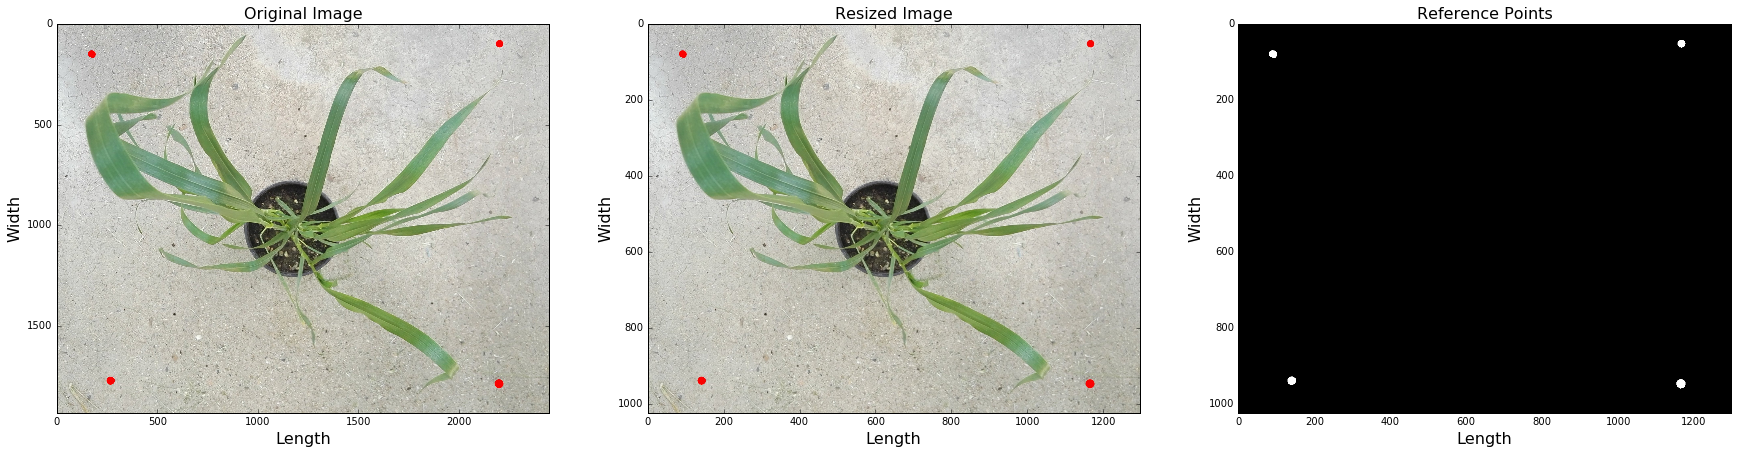

In [19]:
"""Function_2 Red Reference Points Detection"""
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 20))
ax1.set_xlabel('Length', fontsize=16)
ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(img_tmp)
ax2.set_xlabel('Length', fontsize=16)
ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Resized Image', fontsize=16)
ax2.imshow(image_resized)
ax3.set_xlabel('Length', fontsize=16)
ax3.set_ylabel('Width', fontsize=16)
ax3.set_title('Reference Points', fontsize=16)
ax3.imshow(RefPoint_image, cmap = 'gray')
print "Centroids of the red refernce points: ", Ref_Point_Array_Ref
print "Every red reference point contain pixels: ", Ref_Point_Areas

Boundaries of the transformed image:  [[0, 0], [1072, 0], [0, 858], [1072, 858]]


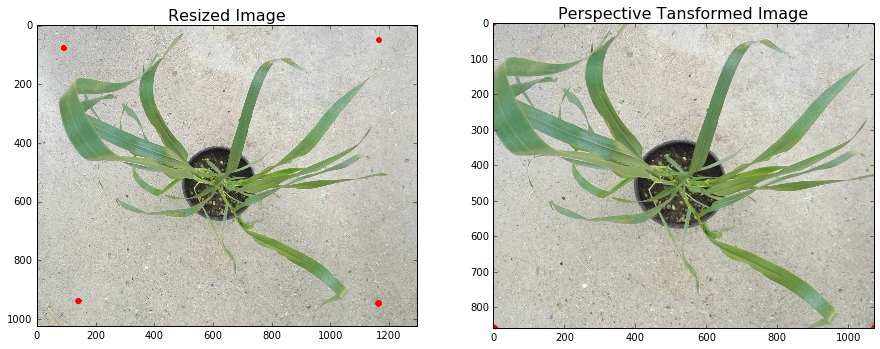

In [20]:
"""Function_5 2D Perspective Tansformation"""
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Resized Image', fontsize=16)
ax1.imshow(image_resized)
#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Perspective Tansformed Image', fontsize=16)
ax2.imshow(Transformed_img, cmap = 'gray')
print "Boundaries of the transformed image: ", New_Ref_Points_Array

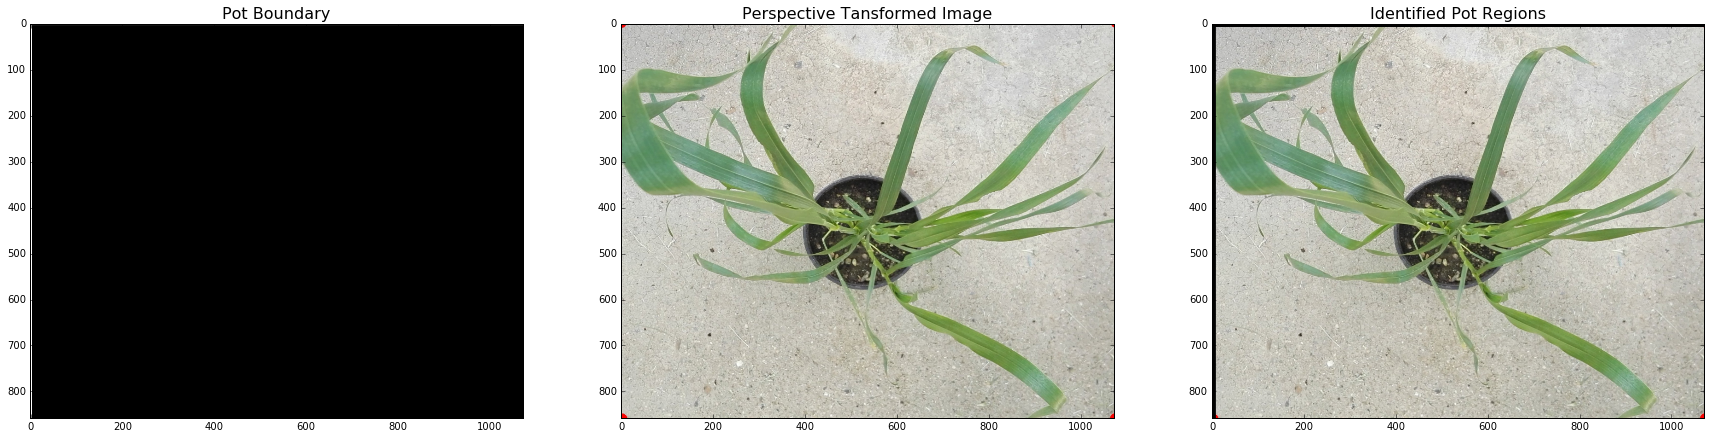

In [21]:
"""Function_6 Generate Pot Regions"""
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Pot Boundary', fontsize=16)
ax1.imshow(Pot_Image, cmap = 'gray')

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Perspective Tansformed Image', fontsize=16)
ax2.imshow(Transformed_img, cmap = 'gray')

#ax3.set_xlabel('Length', fontsize=16)
#ax3.set_ylabel('Width', fontsize=16)
ax3.set_title('Identified Pot Regions', fontsize=16)
# Overlay with resized image
Region_Crop = Transformed_img.copy()
for layer in range(Region_Crop.shape[-1]):
    Region_Crop[np.where(np.invert(Pot_Segment_Refine))] = 1
ax3.imshow(Region_Crop, cmap = 'gray') 

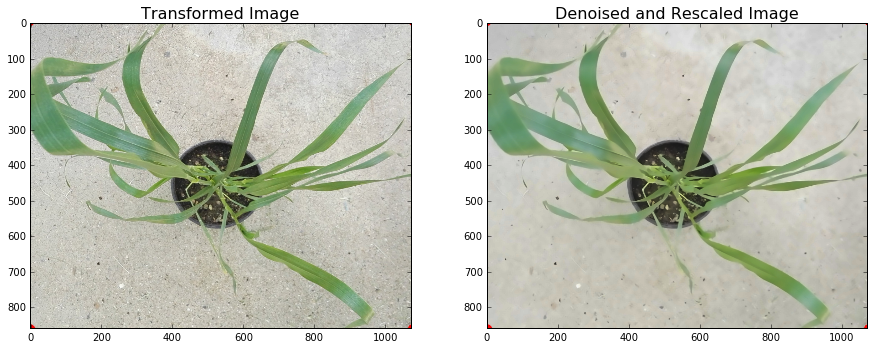

In [22]:
"""Function_7.1 Image Denoise"""
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Transformed Image', fontsize=16)
ax1.imshow(Transformed_img)

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Denoised and Rescaled Image', fontsize=16)
ax2.imshow(Transformed_img_Denoised, cmap = 'gray')

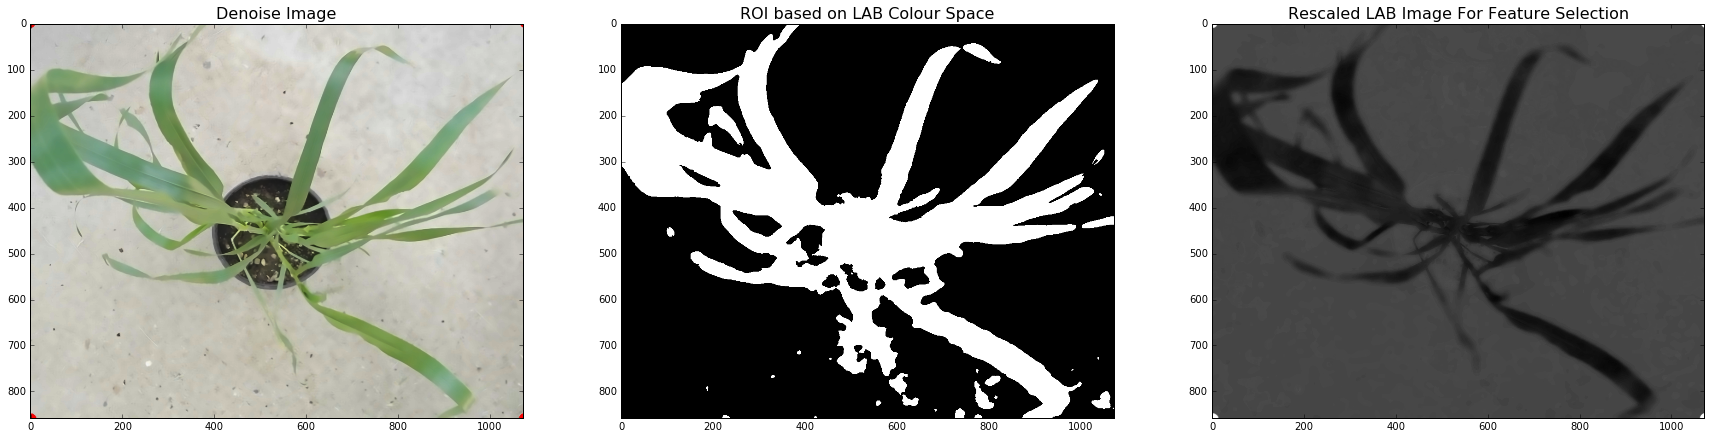

In [23]:
"""Function_7.2 Use LAB Colour Space to Detect ROI"""
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Denoise Image', fontsize=16)
ax1.imshow(Transformed_img_Denoised)

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('ROI based on LAB Colour Space', fontsize=16)
ax2.imshow(dilated_lab_Img, cmap = 'gray')

#ax3.set_xlabel('Length', fontsize=16)
#ax3.set_ylabel('Width', fontsize=16)
ax3.set_title('Rescaled LAB Image For Feature Selection', fontsize=16)
ax3.imshow(leaf_LAB_img_rescale, cmap = 'gray')

The number of pixel groups found:  4


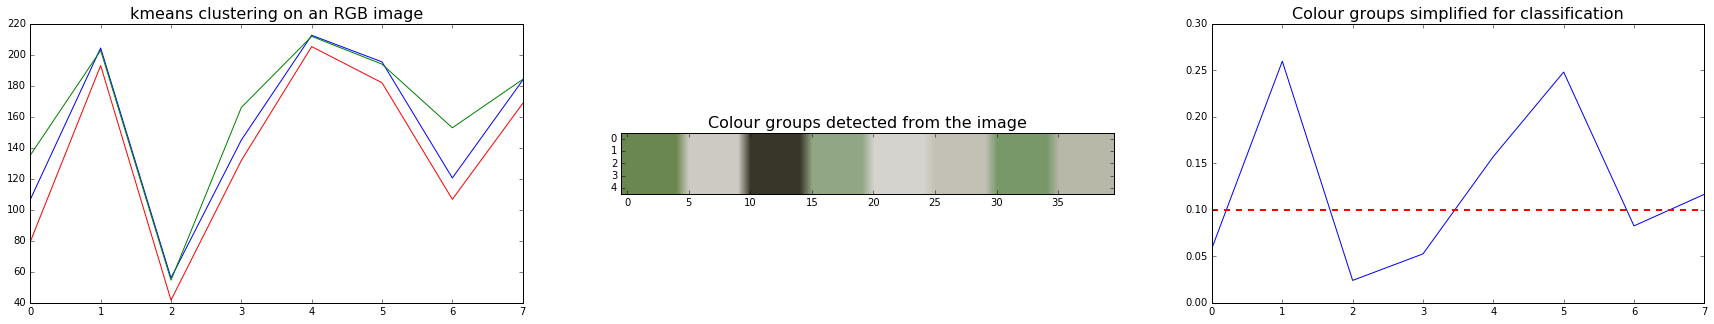

In [24]:
"""Function_8.1 Use kmeans Machine Learning to define pixel groups on the denoised image"""
from sklearn.cluster import KMeans

def show_colours(colours, block_size=5):
    img = np.zeros((block_size,block_size*len(colours),3), np.uint8)
    for i in range(len(colours)):
        a = int(block_size * i)
        b = int(block_size * (i+1))
        img[:, a:b] = colours[i]
    return img

# Prepare the RGB image, rescale it to reduce the computation 
image = Transformed_img_Denoised.copy()
image_rescale = img_as_ubyte(rescale(image, 0.25)) # 25% of the original image
# Reshape the image into three R,G,B arrays 
# image_rescale_ary = image_rescale.reshape((image_rescale.shape[0] * image_rescale.shape[1], 3))
image_rescale_ary = flatten_img(image_rescale)

# cluster the pixel intensities in RGB 
clt = KMeans(n_clusters = 8) # Assume we will have 8 colour clusters from the RGB images
clt.fit(image_rescale_ary) # Fit with RGB arrays

# Normalise the centroids detected from kmeans ML
n_groups = len(np.unique(clt.labels_))
numLabels = np.arange(0, n_groups + 1)
(hist, _) = np.histogram(clt.labels_, bins = numLabels)
hist = hist.astype("float")
hist /= hist.sum() # normalisation 

fig.tight_layout()
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 5))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('kmeans clustering on an RGB image', fontsize=16)
ax1.plot(clt.cluster_centers_)

# Showing the colours of the k-means cluster centres whose frequency in histogram is picked by the algorithm
cluster_colours = clt.cluster_centers_
cluster_colour_img = show_colours(cluster_colours)
ax2.set_title('Colour groups detected from the image', fontsize=16)
ax2.imshow(cluster_colour_img)

# get the number of pixel groups
ax3.set_title('Colour groups simplified for classification', fontsize=16)
ax3.plot(hist)
ax3.plot(range(0, n_groups), [np.median(hist)] * n_groups, 'r', linestyle='--', linewidth = 2)

selected_clusters = hist >= np.median(hist)
# get the number of pixel groups
pixel_groups = np.sum(selected_clusters)
print 'The number of pixel groups found: ', pixel_groups


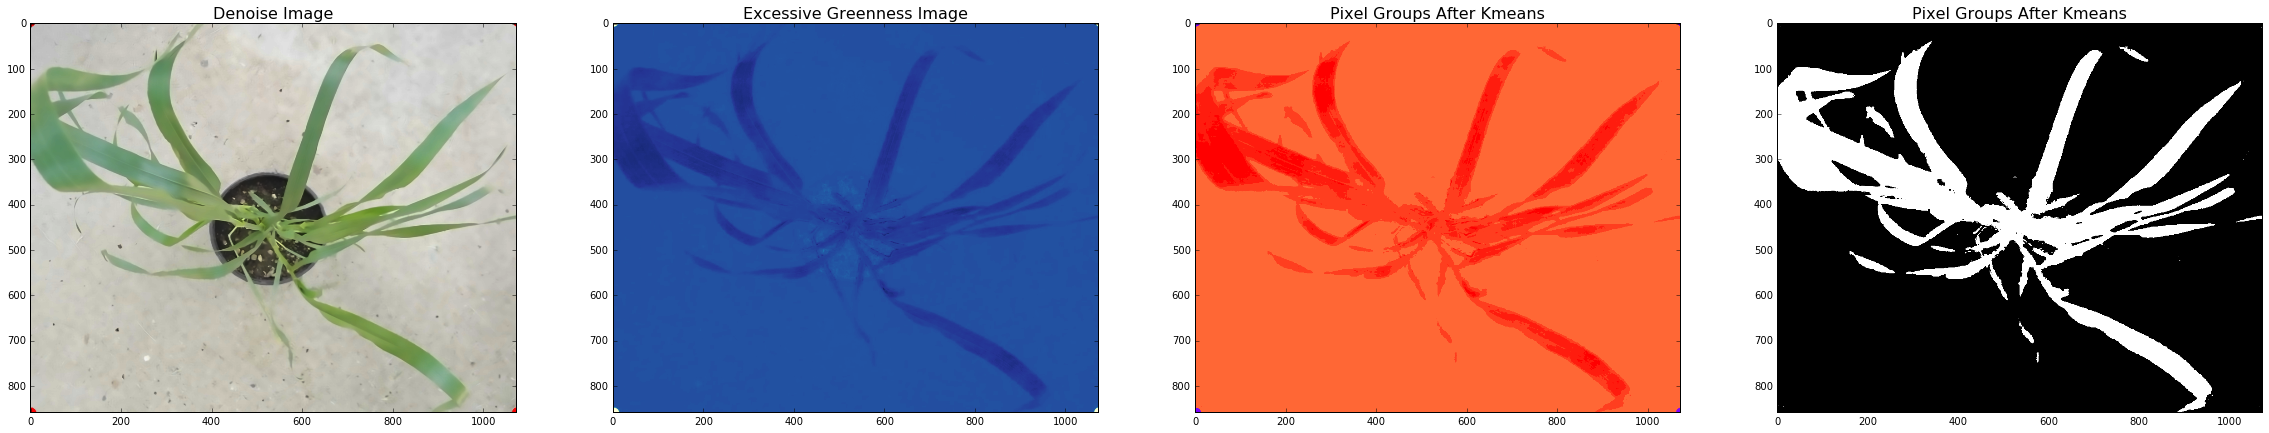

In [25]:
"""Function_8.2 Use Excessive greenness and kmeans Machine Learning to define pixel clustering """
fig.tight_layout()

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols=4, nrows=1, figsize=(40, 30))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Denoise Image', fontsize=16)
ax1.imshow(Transformed_img_Denoised)

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Excessive Greenness Image', fontsize=16)
ax2.imshow(img_EGreen, cmap = 'YlGnBu')


#ax3.set_xlabel('Length', fontsize=16)
#ax3.set_ylabel('Width', fontsize=16)
ax3.set_title('Pixel Groups After Kmeans', fontsize=16)
ax3.imshow(kmeans_img_final, cmap='rainbow')

#ax4.set_xlabel('Length', fontsize=16)
#ax4.set_ylabel('Width', fontsize=16)
ax4.set_title('Pixel Groups After Kmeans', fontsize=16)
ax4.imshow(kmeans_mask, cmap = 'gray')


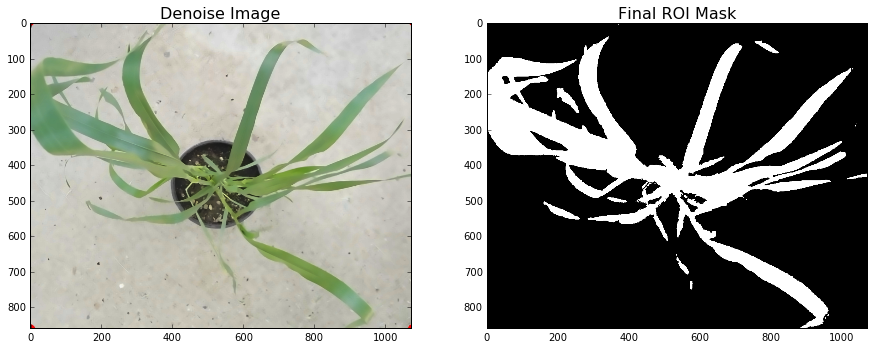

In [26]:
"""Function_8.3 Finalise Mask for Feature Selection"""
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Denoise Image', fontsize=16)
ax1.imshow(Transformed_img_Denoised)

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Final ROI Mask', fontsize=16)
ax2.imshow(leaf_mask_ref, cmap = 'gray')


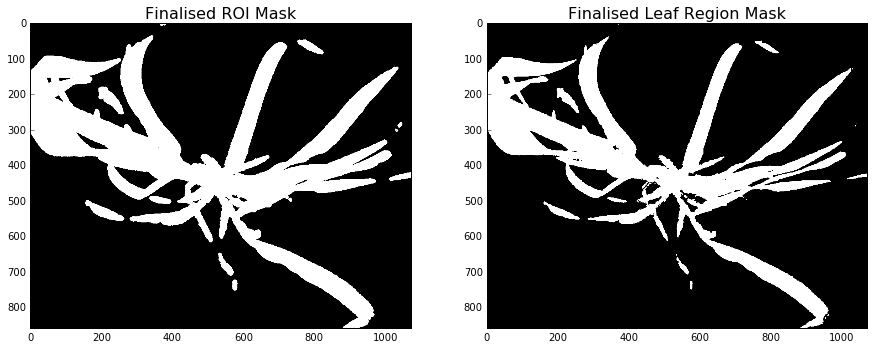

In [27]:
"""Function_9.1 Leaf level measurements - Refine Leaf Regions"""
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Finalised ROI Mask', fontsize=16)
ax1.imshow(dilation(leaf_mask_final, disk(2)), cmap = 'gray')

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Finalised Leaf Region Mask', fontsize=16)
ax2.imshow(leaf_mask_ref_1, cmap = 'gray')

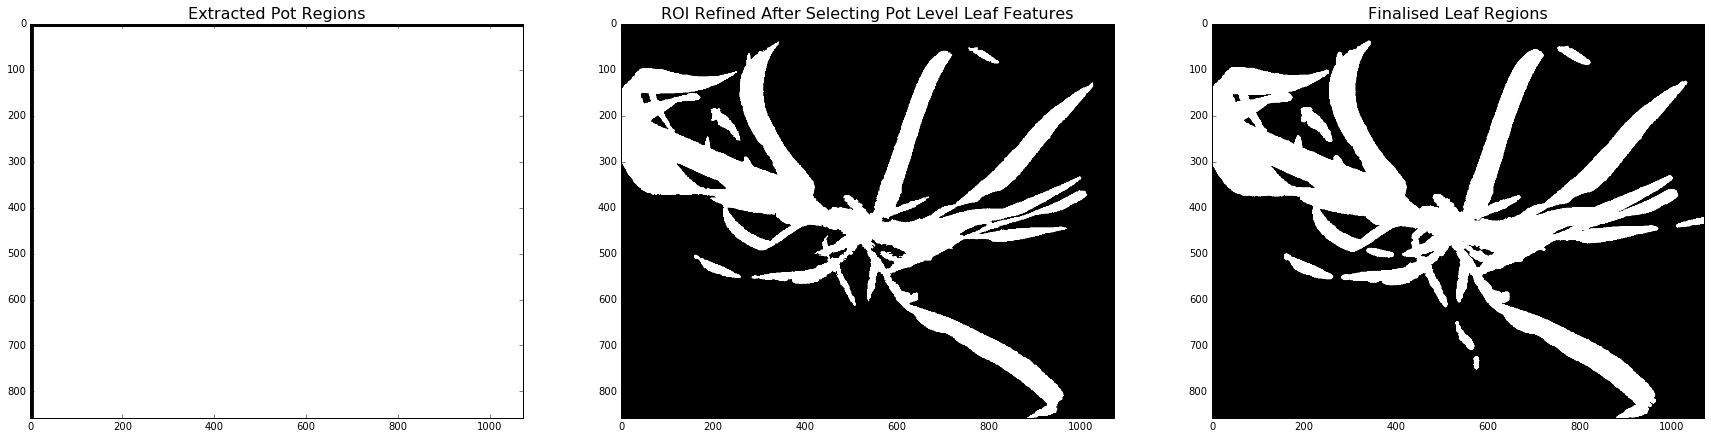

In [28]:
"""Function_9.2 Leaf level measurements - Loop Through Every Pot"""
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(30, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Extracted Pot Regions', fontsize=16)
ax1.imshow(Pot_Segment_Refine, cmap = 'gray')

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('ROI Refined After Selecting Pot Level Leaf Features', fontsize=16)
ax2.imshow(Final_Leaf_img, cmap = 'gray')

ax3.set_title('Finalised Leaf Regions', fontsize=16)
ax3.imshow(Final_Leaf_Clean, cmap = 'gray')

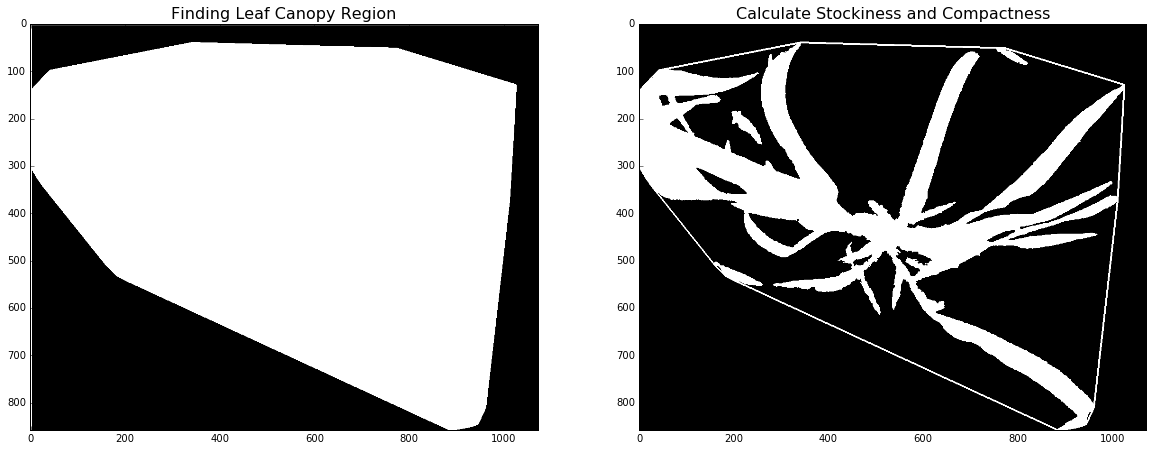

In [29]:
"""Function_9.4 Leaf level measurements - Leaf Canopy"""
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 20))
#ax1.set_xlabel('Length', fontsize=16)
#ax1.set_ylabel('Width', fontsize=16)
ax1.set_title('Finding Leaf Canopy Region', fontsize=16)
ax1.imshow(np.logical_or(Leaf_hull_Final, Pot_Image), cmap = 'gray')

#ax2.set_xlabel('Length', fontsize=16)
#ax2.set_ylabel('Width', fontsize=16)
ax2.set_title('Calculate Stockiness and Compactness', fontsize=16)
ax2.imshow(np.logical_or(dilation(Leaf_hull_Outline_Final, disk(1)), Final_Leaf_img), cmap = 'gray')

In [30]:
###################################################################
#                      END of the functions                       #
###################################################################